In [24]:
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.stats import linregress

import cartopy.crs as ccrs
import cartopy.mpl.ticker as cticker
from cartopy.util import add_cyclic_point
import cartopy.feature as feature
from cartopy.io.shapereader import Reader
from cartopy.feature import ShapelyFeature

##### Importing the North Atlantic Oscillation Climate Index

In [2]:
path='/home/pdirmeye/classes/clim680_2022/CLIM_INDICES/'
file='nao.data'
index_name='nao'

df=pd.read_table(path+file,skiprows=1,
                 header=None,delim_whitespace=True,
                 index_col=0,parse_dates=True,
                 na_values=['-99.9','-99.90'])
df.drop(df.tail(3).index,inplace=True)

In [3]:
start_date=str(df.index[0])+'-'+str(df.columns[0])+'-01'
end_date=str(df.index[-1])+'-'+str(df.columns[-1])+'-01'
print(start_date)

1948-1-01


In [4]:
dates=pd.date_range(start=start_date,end=end_date,freq='MS')
dates

DatetimeIndex(['1948-01-01', '1948-02-01', '1948-03-01', '1948-04-01',
               '1948-05-01', '1948-06-01', '1948-07-01', '1948-08-01',
               '1948-09-01', '1948-10-01',
               ...
               '2020-03-01', '2020-04-01', '2020-05-01', '2020-06-01',
               '2020-07-01', '2020-08-01', '2020-09-01', '2020-10-01',
               '2020-11-01', '2020-12-01'],
              dtype='datetime64[ns]', length=876, freq='MS')

In [5]:
clim_index=df.T.unstack().values
clim_index=clim_index.astype('float32')

In [6]:
ds_index=xr.DataArray(clim_index, coords={'time':dates}, dims=['time'])        
ds_index=ds_index.to_dataset(name='nao')
ds_index

<xarray.Dataset>
Dimensions:  (time: 876)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2020-12-01
Data variables:
    nao      (time) float32 nan nan nan nan nan nan ... 0.03 1.11 nan nan nan

##### Organizing the nao values by season

In [7]:
ds_index_g = ds_index.groupby('time.season').groups

##### Specifying the selection of the cold months (DJF)

In [8]:
ds_index_D = ds_index_g['DJF']

##### Creating a new dataset in which only the DJF values are included

In [9]:
ds_index_DJF = ds_index.isel(time=ds_index_D)
ds_index_DJF

<xarray.Dataset>
Dimensions:  (time: 219)
Coordinates:
  * time     (time) datetime64[ns] 1948-01-01 1948-02-01 ... 2020-12-01
Data variables:
    nao      (time) float32 nan nan nan nan nan nan ... -0.11 1.02 1.05 0.98 nan

##### Grouping the new dataset into mean values by year

In [10]:
dg_index_DJF = ds_index_DJF.groupby('time.year').mean()

##### Opening my dataset

In [11]:
file='/home/jstiles4/clim680_dataset/ERA5_Reanalysis_Precip_dataset.grib'
ds=xr.open_dataset(file)
ds

<xarray.Dataset>
Dimensions:     (time: 252, latitude: 41, longitude: 53)
Coordinates:
    number      int64 ...
  * time        (time) datetime64[ns] 1989-12-31T18:00:00 ... 2010-11-30T18:0...
    step        timedelta64[ns] ...
    surface     float64 ...
  * latitude    (latitude) float64 48.0 47.75 47.5 47.25 ... 38.5 38.25 38.0
  * longitude   (longitude) float64 -80.0 -79.75 -79.5 ... -67.5 -67.25 -67.0
    valid_time  (time) datetime64[ns] ...
Data variables:
    tp          (time, latitude, longitude) float32 ...
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-11-21T20:04 GRIB to CDM+CF via cfgrib-0.9.1...

##### Converting the tp values from m/day to mm/day by multiplying by 1000

In [12]:
ds = ds*1000

##### Completing the same process as with the climate index to create a new version of my dataset that only includes values during the cold months (DJF)

In [13]:
dg = ds.groupby('time.season').groups

In [14]:
dg_D = dg['DJF']

In [15]:
ds_DJF = ds.isel(time=dg_D)
ds_DJF

<xarray.Dataset>
Dimensions:     (time: 63, latitude: 41, longitude: 53)
Coordinates:
    number      int64 0
  * time        (time) datetime64[ns] 1989-12-31T18:00:00 ... 2010-02-28T18:0...
    step        timedelta64[ns] 12:00:00
    surface     float64 0.0
  * latitude    (latitude) float64 48.0 47.75 47.5 47.25 ... 38.5 38.25 38.0
  * longitude   (longitude) float64 -80.0 -79.75 -79.5 ... -67.5 -67.25 -67.0
    valid_time  (time) datetime64[ns] 1990-01-01T06:00:00 ... 2010-03-01T06:0...
Data variables:
    tp          (time, latitude, longitude) float32 2.224 2.3 ... 6.441 6.676
Attributes:
    GRIB_edition:            1
    GRIB_centre:             ecmf
    GRIB_centreDescription:  European Centre for Medium-Range Weather Forecasts
    GRIB_subCentre:          0
    Conventions:             CF-1.7
    institution:             European Centre for Medium-Range Weather Forecasts
    history:                 2022-11-21T20:04 GRIB to CDM+CF via cfgrib-0.9.1...

##### Grouping my dataset by year to match with the climate index

In [16]:
dg_DJF = ds_DJF.tp.groupby('time.year').mean()

##### Calculating the DJF anomalies for each year within the 1990-2010 time frame

In [17]:
da_climo = dg_DJF.mean()
da_anoms = dg_DJF-da_climo
da_anoms

<xarray.DataArray 'tp' (year: 22, latitude: 41, longitude: 53)>
array([[[-0.90167403, -0.8253801 , -0.7242906 , ...,  0.12638688,
          0.19886613,  0.36194444],
        [-0.9484041 , -0.84540725, -0.74431777, ...,  0.23415208,
          0.27229905,  0.16834855],
        [-0.8539903 , -0.7576692 , -0.690912  , ...,  0.39055467,
          0.39055467,  0.2856505 ],
        ...,
        [ 1.3861907 ,  0.85880876,  0.28755784, ...,  2.1987212 ,
          2.3360503 ,  2.4085295 ],
        [ 0.87025285,  0.59559464,  0.32189012, ...,  2.5754225 ,
          2.6746047 ,  2.7919066 ],
        [ 0.5755675 ,  0.57652116,  0.53932786, ...,  2.8920424 ,
          2.9874098 ,  3.264929  ]],

       [[-1.604532  , -1.5326885 , -1.4341422 , ..., -1.3823259 ,
         -1.3928163 , -1.3708818 ],
        [-1.6445863 , -1.5460399 , -1.4474937 , ..., -1.323516  ,
         -1.3352779 , -1.3597556 ],
        [-1.601353  , -1.5152045 , -1.4617988 , ..., -1.2116182 ,
         -1.2100288 , -1.2338706 ],
...
        [ 0.0113101 , -0.31929684, -0.6664343 , ...,  3.3119771 ,
          3.3231032 ,  3.2639754 ],
        [-0.00839901, -0.34790707, -0.61461806, ...,  3.800576  ,
          3.7204673 ,  3.6600683 ],
        [-0.1864183 , -0.52592635, -0.6136644 , ...,  4.389947  ,
          4.2723274 ,  4.2672405 ]],

       [[-2.315973  , -2.2873628 , -2.263521  , ..., -0.93505263,
         -0.94554305, -0.93409896],
        [-2.3255098 , -2.342676  , -2.3197877 , ..., -0.939821  ,
         -0.8816469 , -0.72238326],
        [-2.348398  , -2.3579347 , -2.3417222 , ..., -0.8835542 ,
         -0.81488967, -0.6546724 ],
        ...,
        [ 0.5078566 ,  0.10063767, -0.11680007, ...,  3.575827  ,
          3.575827  ,  3.8085234 ],
        [ 0.08347154, -0.26652694, -0.35140395, ...,  4.0269146 ,
          4.1699657 ,  4.392172  ],
        [-0.2455461 , -0.4725206 , -0.35045028, ...,  4.3282757 ,
          4.518057  ,  4.775549  ]]], dtype=float32)
Coordinates:
    number     int64 0
    step       timedelta64[ns] 12:00:00
    surface    float64 0.0
  * latitude   (latitude) float64 48.0 47.75 47.5 47.25 ... 38.5 38.25 38.0
  * longitude  (longitude) float64 -80.0 -79.75 -79.5 ... -67.5 -67.25 -67.0
  * year       (year) int64 1989 1990 1991 1992 1993 ... 2007 2008 2009 2010

##### Creating a slice of NAO index that has the same year dimension as my dataset

In [18]:
dg_index_DJF = dg_index_DJF.sel(year=slice(da_anoms['year'][0],da_anoms['year'][-1]))
dg_index_DJF

<xarray.Dataset>
Dimensions:  (year: 22)
Coordinates:
  * year     (year) int64 1989 1990 1991 1992 1993 ... 2006 2007 2008 2009 2010
Data variables:
    nao      (year) float32 0.5067 0.6567 0.5233 ... 0.1867 -0.9267 -2.097

##### This is where I compute the linear regression between my dataset and the NAO climate index at each latitude and longitude range within the Northeast U.S. Here, the climate index (dg_index_DJF) is the independent variable and the calculated anomalies are the dependent variables

In [19]:
nx = len(da_anoms['longitude'])
ny = len(da_anoms['latitude'])

p_array = np.zeros((ny,nx))
r_array = np.zeros((ny,nx))
m_array = np.zeros((ny,nx))

x =       dg_index_DJF['nao']

for j in range(ny):
    print(f"{j},",end=" ")
    for i in range(nx):
        
        y = da_anoms[:,j,i]
        
        m,b,r,p,e = linregress(x,y)
        
        m_array[j,i] = m
        r_array[j,i] = r
        p_array[j,i] = p
print("*** DONE ***")

0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26, 27, 28, 29, 30, 31, 32, 33, 34, 35, 36, 37, 38, 39, 40, *** DONE ***


##### Creating a mask of the areas where the regression is significant

In [20]:
mask_sig = np.where(p_array<0.05,m_array,np.nan)

##### The plot of the regression coefficient throughout the Northeast U.S. is shown here. Only a few areas display a strong regression coefficient, those being the section of New Hampshire near the Atlantic Ocean which shows a strong negative coefficient, and the far southwestern section of the region around northern West Virginia which displays a strong positive coefficient. Overall, the Cold Month Northeast U.S. precipitation and North Atlantic Oscillation show a weak relationship due to the small number of areas with discernable significance.

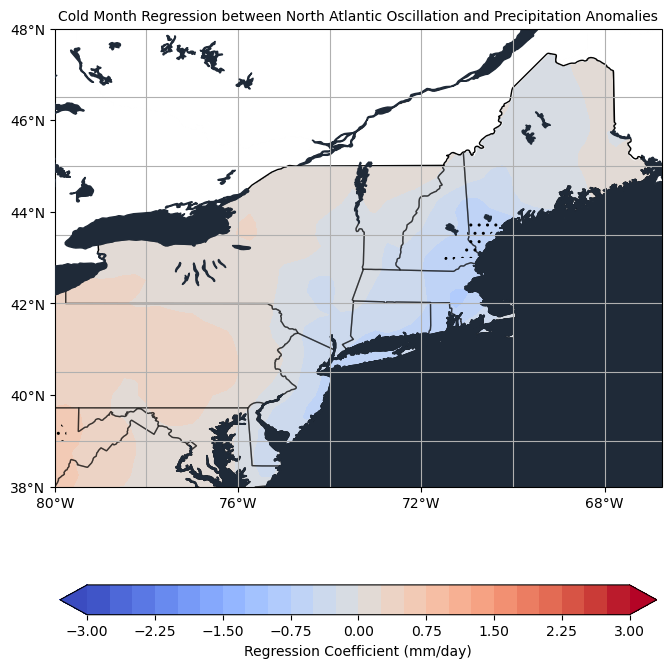

In [25]:
clevs=np.arange(-3,3.25,0.25)

fig = plt.figure(figsize=(11,8.5))

ax = plt.axes(projection=ccrs.PlateCarree(central_longitude=-74))

data = m_array
data,lon = add_cyclic_point(data,coord=da_anoms['longitude'])
mask_data,lons = add_cyclic_point(mask_sig,coord=da_anoms['longitude'])

cs = ax.contourf(lon,da_anoms['latitude'],
            data,clevs,
            transform=ccrs.PlateCarree(),
            cmap='coolwarm',extend='both')

ax.contourf(lon,da_anoms['latitude'],mask_data,[0,1],
            transform = ccrs.PlateCarree(),colors='None',
            hatches=['..','..'],extend='both',alpha=0)

ax.coastlines()

ax.gridlines()
ax.add_feature(feature.OCEAN, zorder=2, color='#1F2A38')
ax.add_feature(feature.BORDERS, zorder=2, color='k')
ax.add_feature(feature.LAKES, zorder=3, color='#1F2A38')
ax.add_feature(feature.BORDERS.with_scale('10m'),
               linestyle='-', alpha=.5)
ax.add_feature(feature.STATES.with_scale('10m'),
               linestyle='-', alpha=.5)
fname='/home/jstiles4/gadm41_CAN_1.shp'
shape_feature = ShapelyFeature(Reader(fname).geometries(), ccrs.PlateCarree(), edgecolor='black', color='white')
        
ax.add_feature(shape_feature)
 
ax.set_xticks([-80,-76,-72,-68],crs=ccrs.PlateCarree())
lon_formatter = cticker.LongitudeFormatter()
ax.xaxis.set_major_formatter(lon_formatter)

ax.set_yticks([38,40,42,44,46,48],crs=ccrs.PlateCarree())
lat_formatter = cticker.LatitudeFormatter()
ax.yaxis.set_major_formatter(lat_formatter)

cbar = plt.colorbar(cs,orientation='horizontal',shrink=0.7,
                 label='Regression Coefficient (mm/day)')

plt.title('Cold Month Regression between North Atlantic Oscillation and Precipitation Anomalies',fontsize=10) ;